# 4.3. Predicting House Prices: A Regression Example
- Not: Regression != Logistic Regression (Classification Algorithm).

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# import tensorflow
from tensorflow.keras.datasets import boston_housing
from tensorflow import keras
from tensorflow.keras import layers

# 4.3.1: Boston Housing Price Dataset
- About: Predict the median price of homes ina given Boston suburd in a mid-1970s, given data points about the suburb at the time, such as the crime rate, the local property tax rate,...
- There are 506 total data points: 404 training and 102 testing.
- The features has different types and scale

In [2]:
# load dataset
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [3]:
print(train_data.shape)

(404, 13)


In [4]:
print(train_targets.shape)

(404,)


In [5]:
# check shape
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [6]:
print(train_targets)

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 21.1 13.6
 32.2 13.1

# 4.3.2. Data Processing
- It is problematic to feed NN values that take wildly different ranges. The model might be able to automatically adapt to heterogeneous data but it will make the learning difficult. Thus, we should do feature normalization: 
- For each feature in the input data:
    - Subtract the mean of the feature
    - Divide by standard deviation
    - Feature is centered around 0 and has a unit standard deviation

In [7]:
# normalized data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

# note that we normalize the test data based on the training data.
# you should never use any quantity computed on the test data in the workflow as you don't want the model to learn from test data
test_data -= mean
test_data /= std

In [8]:
print(train_data.shape)

(404, 13)


In [9]:
print(train_targets.shape)

(404,)


# 4.3.3. Modeling
- As the dataset is smalle, we should use small model.

In [10]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1) # scalare regression (cont values). If there is a sigmoid, then the model can only learn to predict value 0 and 1. Here the model can predict any range
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"]) # mse is good for regression
    return model

**Note**: We’re also monitoring a new metric during training: mean absolute error (MAE). It’s the absolute value of the difference between the predictions and the targets. For instance, an MAE of 0.5 on this problem would mean your predictions are off by $500 on average.

# 4.3.4. Validate Model Using K-fold
- Split data into training set and validation set.
- However, as we have VERY few points, then validation set will be small.
    - This means that the validation scores might change a lot depending on which data points we choose for validation and which for taining.
    - The validation score might have high variance with regard to the validation split
    - This prevent us from reliably evaluating model.

In [11]:
# k-fold validation: 4 folds and dataset divided to 4 equal section (train 3, test 1)
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
         axis = 0
    )
    partial_train_targets = np.concatenate(
         [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
         axis=0
    )
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, 
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    

Processing fold #0


2023-02-16 23:23:53.219099: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-02-16 23:23:53.559921: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Processing fold #1
Processing fold #2
Processing fold #3


In [12]:
print(all_scores)

[1.8980035781860352, 2.378835916519165, 2.4498393535614014, 2.3938705921173096]


In [13]:
# score == mae loss
print(np.mean(all_scores))

2.280137360095978


**Note**: The different runs do indeed show rather different validation scores, from 2.1 to 3.1. The average (2.6) is a much more reliable metric than any single score—that’s the entire point of K-fold cross-validation. 

**Note**: In this case, we’re off by 2,600 on average, which is significant considering that the prices range from 10,000 to 50,000.

In [14]:
# Let's train longer and save validation to log for each fold
num_epochs = 500

all_mae_histories = []

for i in range(k):
    print(f"Processing fold #{i}")
    
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model()
    
    history = model.fit(partial_train_data, partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [15]:
print(all_mae_histories)

[[19.381399154663086, 16.37049102783203, 12.428024291992188, 8.168319702148438, 5.09605073928833, 4.027954578399658, 3.508957862854004, 3.2509169578552246, 3.1855297088623047, 3.0275819301605225, 2.938176155090332, 2.674696922302246, 2.552906036376953, 2.4829461574554443, 2.4800140857696533, 2.4132494926452637, 2.363785743713379, 2.3114147186279297, 2.3548507690429688, 2.2884912490844727, 2.221813440322876, 2.1390044689178467, 2.110128879547119, 2.181361675262451, 2.059046983718872, 2.154954195022583, 1.9936619997024536, 2.1723504066467285, 2.1036691665649414, 2.01346755027771, 1.9521653652191162, 1.9404988288879395, 1.915734887123108, 2.0729217529296875, 2.033702850341797, 2.096295118331909, 1.950346827507019, 2.067100763320923, 1.9332624673843384, 2.0032665729522705, 1.9245848655700684, 1.842084527015686, 1.8724253177642822, 1.9757431745529175, 1.9092270135879517, 1.914620280265808, 1.9281346797943115, 1.9061590433120728, 1.9335732460021973, 1.9158886671066284, 1.8409589529037476, 1.

In [16]:
# basically, the matrix store 500 epochs (times) that re run K-fold and for each epoch we have 4 mae from a k-fold of that epoch.
print(np.array(all_mae_histories).shape)

(4, 500)


**Note**: all_mae_histories store 4 fold and each fold store 500 times that we train the model

In [17]:
# average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

average_mae_history = []

# go thru 500 epochs
for i in range(num_epochs):
    temp = []
    
    # go thru each fold and get the mae at that epoch
    for x in all_mae_histories:
        temp.append(x[i])
    
    # calculate the mean mae for that epoch
    temp = np.mean(temp)
    
    # store in the average mae log
    average_mae_history.append(temp)

In [18]:
# print sample
print(all_mae_histories[0])

[19.381399154663086, 16.37049102783203, 12.428024291992188, 8.168319702148438, 5.09605073928833, 4.027954578399658, 3.508957862854004, 3.2509169578552246, 3.1855297088623047, 3.0275819301605225, 2.938176155090332, 2.674696922302246, 2.552906036376953, 2.4829461574554443, 2.4800140857696533, 2.4132494926452637, 2.363785743713379, 2.3114147186279297, 2.3548507690429688, 2.2884912490844727, 2.221813440322876, 2.1390044689178467, 2.110128879547119, 2.181361675262451, 2.059046983718872, 2.154954195022583, 1.9936619997024536, 2.1723504066467285, 2.1036691665649414, 2.01346755027771, 1.9521653652191162, 1.9404988288879395, 1.915734887123108, 2.0729217529296875, 2.033702850341797, 2.096295118331909, 1.950346827507019, 2.067100763320923, 1.9332624673843384, 2.0032665729522705, 1.9245848655700684, 1.842084527015686, 1.8724253177642822, 1.9757431745529175, 1.9092270135879517, 1.914620280265808, 1.9281346797943115, 1.9061590433120728, 1.9335732460021973, 1.9158886671066284, 1.8409589529037476, 1.8

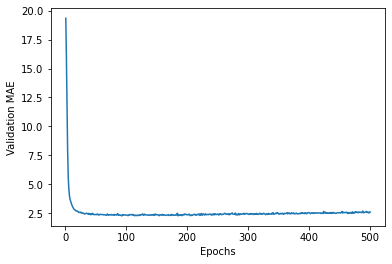

In [19]:
# plot validation score from history
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Note on analysis:** the validation MAE for the first few epochs is dramatically higher than the values that follow. Let’s omit the first 10 data points, which are on a different scale than the rest of the curve.

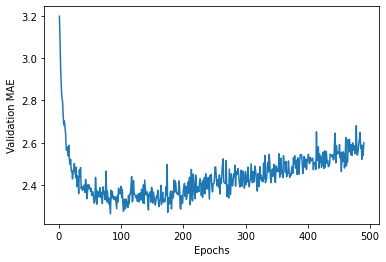

In [20]:
# plot the validation score, excluding the first 10 data points
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Note on analysis:** validation MAE stops improving significantly after 120–140 epochs (this number includes the 10 epochs we omitted). Past that point,
we start overfitting.

In [21]:
# train final model from what we learn: aka epochs=130
model = build_model()

model.fit(train_data, train_targets, epochs=140, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 11.7056 - mae: 2.2746


In [22]:
print(test_mae_score)

2.2746024131774902


**Note**: We’re still off by a bit under 2,500. It’s an improvement! Not really as in the book, before 500 epochs, the MAE is off by 2600 dollars in average (mae=~2.6) and after 140 epochs training will go down.

**Thus, K-fold is helpful to find suitable number of epochs and suitable for small dataset!**

# 4.3.5. Generate Prediction On New Data

In [23]:
predictions = model.predict(test_data)
print(predictions[0])

[8.396875]
